

**Prepare the data:** create random samples of 200 documents of each book, representative of the source input.

**Preprocess the data:** prepare the records of 150 words records for each document, 

Label them as a, b, c etc. as per the book they belong to so can later compare with clusters.

**Transform** to BOW and TF-IDF (also use other features LDA, Word-Embedding).

Use at least K-means, EM, Hierarchical clustering algorithms to compare.

**Evaluation:** Calculate Kappa against true authors, Consistency, Coherence and Silhouette.

**Perform Error-Analysis:** Identity what were the characteristics of the instance records that threw the machine off, using the top 10 frequent words and/or top collocations.

Document your steps, explain the results effectively, using graphs.

Verify and validate your programs; Make sure your programs run without syntax or logical errors.

## Environment Setup

In [51]:
# Data manipulation Packages
import numpy as np
import pandas as pd
import string
import re

# Data Visualization Packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

# Scikit-Learn Packages
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Gensim packages
from gensim.models import Word2Vec
from spacy import displacy
from gensim.models import Phrases
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency
import multiprocessing

import logging
import spacy

# Natural Language Processing Packages
import nltk
nltk.download('gutenberg')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Machine Learning Packages
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, ward

import sklearn.manifold
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**KMeans Clustering**

K-means is a centroid-based algorithm, or a distance-based algorithm, where we calculate the distances to assign a point to a cluster. In K-Means, each cluster is associated with a centroid. K-Means Clustering is a simple yet powerful algorithm in data science.

**Gaussian Mixture Models**

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

**Agglomerative Clustering**

The agglomerative clustering is the most common type of hierarchical clustering used to group objects in clusters based on their similarity. It’s also known as AGNES (Agglomerative Nesting). The algorithm starts by treating each object as a singleton cluster. Next, pairs of clusters are successively merged until all clusters have been merged into one big cluster containing all objects. The result is a tree-based representation of the objects, named dendrogram.


**What is Silhouette Score?**

Silhouette score checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is.

Since we already know that the fitting procedure is not deterministic, we run twenty fits for each number of clusters, then we consider the mean value and the standard deviation of the best five runs.

**What is Bayesian Information Criterion (BIC)?**

This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC, the better is the model to actually predict the data we have. In order to avoid overfitting, this technique penalizes models with big number of clusters

## Data Preparation

In [52]:
# Dataset according to the requirements of the assignment

tokenizer = RegexpTokenizer('\s+', gaps=True)
Book_dict={"A":"austen-emma.txt", "B":"bible-kjv.txt", "C":"carroll-alice.txt",
           "D":"chesterton-thursday.txt", "E":"shakespeare-caesar.txt"}
Sampling=[]
Records=[]
for index_count in Book_dict:
    doc = ""
    labeled_docs=[]
    count,j=0,0
    text=nltk.corpus.gutenberg.raw(Book_dict[index_count])
    tokenized_word=tokenizer.tokenize(text)
    for i, word in enumerate(tokenized_word):
        if(j<151):
            if(re.search('\w',word) and word!=''):
                doc=doc+' '+word
            else:
                doc=doc+word
            j+=1
        else:
            count+=1
            j=0
            labeled_docs.append(doc)
            doc=word
    ser=pd.Series(labeled_docs)
    for i in ser.sample(200, replace=True).values:
        Sampling.append(i)
        Records.append(index_count)
df = pd.DataFrame(list(zip(Sampling,Records)), columns=["Data", "Target"])

In [53]:
# Function to remove punctuations and stopwords
def text_process(words):
    remove_punc = [char for char in words if char not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

In [54]:
df.head()

,Data,Target
0,"likeness, to every morning visitor in Brunswic...",A
1,"anticipated. As she sat one morning, looking f...",A
2,"then said."" ""No, indeed,"" cried Emma, most hap...",A
3,idea--I cannot guess it in the least. What can...,A
4,"says.'"" Emma's politeness was at hand directly...",A


In [55]:
df.shape

(1000, 2)

## Data Transformations

### Bag-of-Words (BOW)

In [56]:
np.random.seed(42)
# Bag-of-Words
bow_fit = CountVectorizer(analyzer=text_process).fit(df['Data'])
bow_transform = bow_fit.transform(df['Data'])

print('Vocabulary Length: ', len(bow_fit.vocabulary_))
print('Vocabulary: ', bow_fit.vocabulary_.keys())
print('Shape of Sparse Matrix: ', bow_transform.shape)
print('Amount of Non-Zero occurences: ', bow_transform.nnz)

Vocabulary Length:  11838
Vocabulary:  dict_keys(['likeness', 'every', 'morning', 'visitor', 'Brunswick', 'Squareand', 'said', 'forswear', 'ever', 'drawing', 'body', 'Harriets', 'sake', 'rather', 'husbands', 'wives', 'case', 'present', 'break', 'resolution', 'Mr', 'Elton', 'seemed', 'properly', 'struck', 'delighted', 'idea', 'repeating', 'indeed', 'observe', 'Exactly', 'interesting', 'consciousness', 'Emma', 'began', 'consider', 'whether', 'better', 'leave', 'together', 'wanted', 'declaration', 'must', 'wait', 'little', 'longer', 'soon', 'fixed', 'size', 'sort', 'portrait', 'wholelength', 'watercolours', 'like', 'John', 'Knightleys', 'destined', 'could', 'please', 'hold', 'honourable', 'station', 'anticipated', 'sat', 'one', 'looking', 'forward', 'exactly', 'close', 'day', 'note', 'brought', 'Mrs', 'Goddard', 'requesting', 'respectful', 'terms', 'allowed', 'bring', 'Miss', 'Smith', 'welcome', 'request', 'girl', 'seventeen', 'knew', 'well', 'sight', 'long', 'felt', 'interest', 'account'

### Term Frequency Inverse Document Frequency (TF-IDF)

In [57]:
np.random.seed(42)

# TF-IDF
tfidf_transform = TfidfTransformer().fit(bow_transform)
tfidf = tfidf_transform.transform(bow_transform)

# Top 20 weighted words
weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': bow_fit.get_feature_names(), 'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False, inplace=True)
weights_df.head(20)

,Term,Weight
9550,said,0.040533
9803,shall,0.025795
837,Alice,0.025521
4846,could,0.017809
7606,like,0.017753
8341,one,0.017550
7420,know,0.017387
11239,unto,0.016763
10834,thou,0.016136
7781,man,0.016093


Text(0.5, 1.0, 'TF-IDF Top 20 Weights')

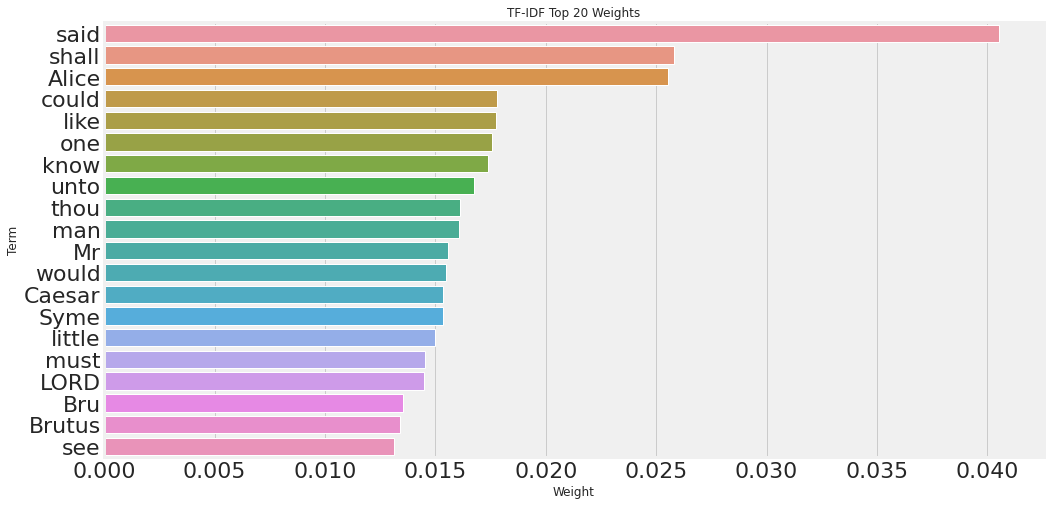

In [58]:
# Visualize top 20 weighted words
fig, ax = plt.subplots(figsize=(15,8))
sns.set_theme(style="whitegrid")
sns.barplot(x=weights_df['Weight'][:20], y=weights_df['Term'][:20], ax=ax)
ax.set_title('TF-IDF Top 20 Weights')

### Word2Vec

In [59]:
from time import time  # To time our operations
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Data'])

t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

Time to clean up everything: 0.12 mins


(744, 1)

In [60]:
np.random.seed(42)
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=5, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(sg=1,
                     seed=2,
                     min_count=5,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)
print("Vocabulary length:", len(w2v_model.wv.vocab))
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:06:03: collecting all words and their counts
INFO - 15:06:03: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:06:03: collected 46365 word types from a corpus of 48349 words (unigram + bigrams) and 744 sentences
INFO - 15:06:03: using 46365 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
INFO - 15:06:03: source_vocab length 46365
INFO - 15:06:04: Phraser built with 115 phrasegrams
INFO - 15:06:04: collecting all words and their counts
INFO - 15:06:04: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:06:04: collected 7473 word types from a corpus of 46744 raw words and 744 sentences
INFO - 15:06:04: Loading a fresh vocabulary
INFO - 15:06:04: effective_min_count=5 retains 1839 unique words (24% of original 7473, drops 5634)
INFO - 15:06:04: effective_min_count=5 leaves 37519 word corpus (80% of original 46744, drops 9225)
INFO - 15:06:04: deleting the raw counts dictionary of 7473 items


Vocabulary length: 1839
Time to build vocab: 0.01 mins


INFO - 15:06:05: training model with 1 workers on 1839 vocabulary and 300 features, using sg=1 hs=0 sample=6e-05 negative=20 window=2
INFO - 15:06:05: worker thread finished; awaiting finish of 0 more threads
INFO - 15:06:05: EPOCH - 1 : training on 46744 raw words (14596 effective words) took 0.4s, 38134 effective words/s
INFO - 15:06:06: worker thread finished; awaiting finish of 0 more threads
INFO - 15:06:06: EPOCH - 2 : training on 46744 raw words (14583 effective words) took 0.8s, 18957 effective words/s
INFO - 15:06:06: worker thread finished; awaiting finish of 0 more threads
INFO - 15:06:06: EPOCH - 3 : training on 46744 raw words (14676 effective words) took 0.6s, 25418 effective words/s
INFO - 15:06:07: worker thread finished; awaiting finish of 0 more threads
INFO - 15:06:07: EPOCH - 4 : training on 46744 raw words (14680 effective words) took 0.5s, 29506 effective words/s
INFO - 15:06:07: worker thread finished; awaiting finish of 0 more threads
INFO - 15:06:07: EPOCH - 5 

Time to train the model: 0.21 mins


WARNING - 15:06:47: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


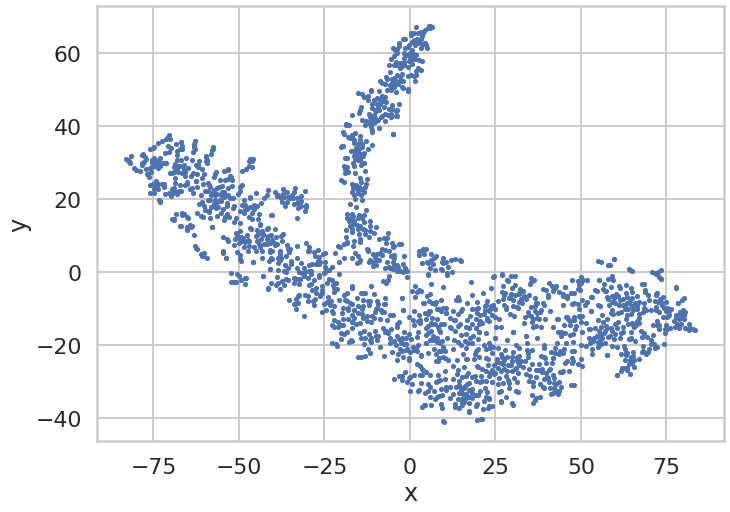

In [61]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

all_word_vectors_matrix = w2v_model.wv.vectors

tsne = sklearn.manifold.TSNE(n_components = 2, 
                             early_exaggeration = 6,
                             learning_rate = 500,
                             n_iter = 2000,
                             random_state = 2)

all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

# Create a dataframe to record each word and its coordinates.
points = pd.DataFrame(
    [(word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[w2v_model.wv.vocab[word].index])
            for word in w2v_model.wv.vocab
        ]],
    columns=["word", "x", "y"])

sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(10, 8))

In [62]:
w2v_model.init_sims(replace=True)
words = list(w2v_model.wv.vocab)
print(words)

INFO - 15:06:47: precomputing L2-norms of word weight vectors


['likeness', 'morning', 'square', 'say', 'draw', 'body', 'harriet', 'sake', 'husband', 'wife', 'case', 'present', 'break', 'mr_elton', 'strike', 'delight', 'idea', 'repeat', 'observe', 'exactly', 'interesting', 'consciousness', 'emma', 'begin', 'consider', 'better', 'leave', 'want', 'wait', 'little', 'longer', 'soon', 'fix', 'size', 'sort', 'length', 'water', 'colour', 'like', 'mr', 'john_knightley', 'hold', 'honourable', 'station', 'sit', 'look', 'forward', 'close', 'day', 'note', 'bring', 'mrs_goddard', 'request', 'term', 'allow', 'miss_smith', 'welcome', 'girl', 'know', 'sight', 'long', 'feel', 'interest', 'account', 'beauty', 'invitation', 'return', 'evening', 'fair', 'harriet_smith', 'natural', 'daughter', 'somebody', 'place', 'year', 'school', 'lately', 'raise', 'condition', 'parlour', 'generally', 'history', 'friend', 'highbury', 'cry', 'happy', 'particularly', 'glad', 'shake', 'hand', 'person', 'thank', 'heart', 'continue', 'time', 'speak', 'feeling', 'happiness', 'turn', 'eye'

In [63]:
X = w2v_model[w2v_model.wv.vocab]
print (X)

[[-0.03310461  0.03100754  0.10259498 ... -0.04036322  0.08289544
   0.03596971]
 [-0.04012126  0.03902035  0.0965608  ... -0.04149002  0.0897164
   0.03169893]
 [-0.04025964  0.03830086  0.0986611  ... -0.04300965  0.09151906
   0.03034852]
 ...
 [-0.01728056  0.01001225  0.10742708 ... -0.03450473  0.06910721
   0.03880577]
 [-0.01599046  0.00497747  0.10546531 ... -0.03438511  0.06678682
   0.03825692]
 [-0.01316883 -0.00078458  0.10390666 ... -0.032586    0.06514163
   0.04153495]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


WARNING - 15:06:47: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


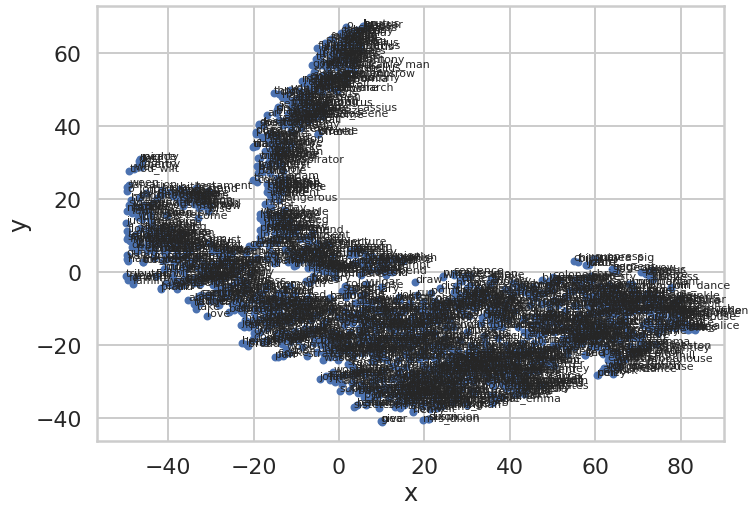

In [64]:
def plot_region(x_bounds, y_bounds):
    '''Plot a limited region with points annotated by the word they represent.'''
    slice = points[(x_bounds[0] <= points.x) & (points.x <= x_bounds[1]) & 
                   (y_bounds[0] <= points.y) & (points.y <= y_bounds[1])]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

plot_region(x_bounds=(-50,100), y_bounds=(-50, 100))

## Implementation of Clustering Algorithms

### KMeans Clustering with TF-IDF

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters


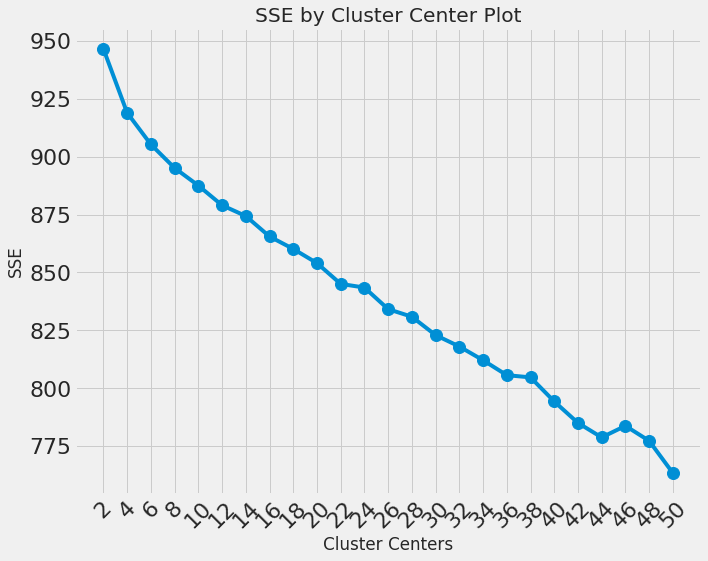

In [79]:
np.random.seed(42)
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(df["Data"])
text = tfidf.transform(df["Data"])

def find_optimal_clusters(data, max_k):
  '''
  Function to find the most optimal clusters for KMeans
  '''
  iters = range(2, max_k+1, 2)
  sse = []
  for k in iters:
    sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
    print('Fit {} clusters'.format(k))
        
  f, ax = plt.subplots(1, 1, figsize=(10, 8))
  ax.plot(iters, sse, marker='o')
  ax.set_xlabel('Cluster Centers')
  ax.set_xticks(iters)
  ax.set_xticklabels(iters, rotation=45)
  ax.set_ylabel('SSE')
  ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 50)

In [66]:
clusters = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

Here we plot the clusters generated by our KMeans operation. One plot uses PCA which is better at capturing global structure of the data. The other uses TSNE which is better at capturing relations between neighbors. In order to speed up the process with TSNE, I sample from 3,000 documents and perform a PCA 50 dimension reduction on the data first. Next I show a scatterplot further sampling the sample down to 300 points.

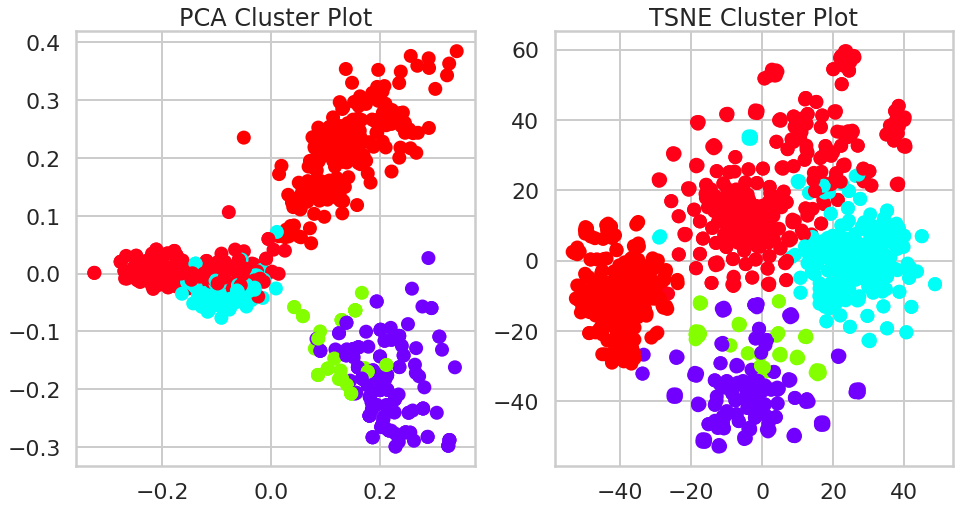

In [67]:
np.random.seed(42)
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=1000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=100).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=1000, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 8))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
#plot_tsne_pca(tfidf, clusters)
plot_tsne_pca(text, clusters)

In [68]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
israel,thee,son,thy,thou,ye,god,shall,lord,unto

Cluster 1
doe,brut,haue,hee,thou,caesar,cassi,caska,cask,sir

Cluster 2
little,knightley,elton,think,weston,miss,harriet,mrs,emma,mr

Cluster 3
vs,thou,antony,cassi,cassius,shall,haue,bru,brutus,caesar

Cluster 4
went,man,don,know,queen,little,like,syme,alice,said


### KMeans Clustering with Word2Vec

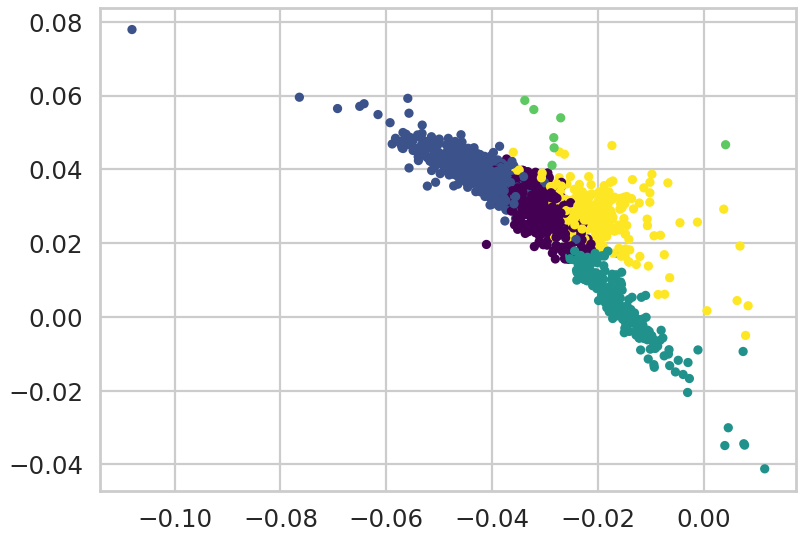

In [69]:
kmeans = KMeans(5, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

**Silhoette Score**

Text(0, 0.5, 'Score')

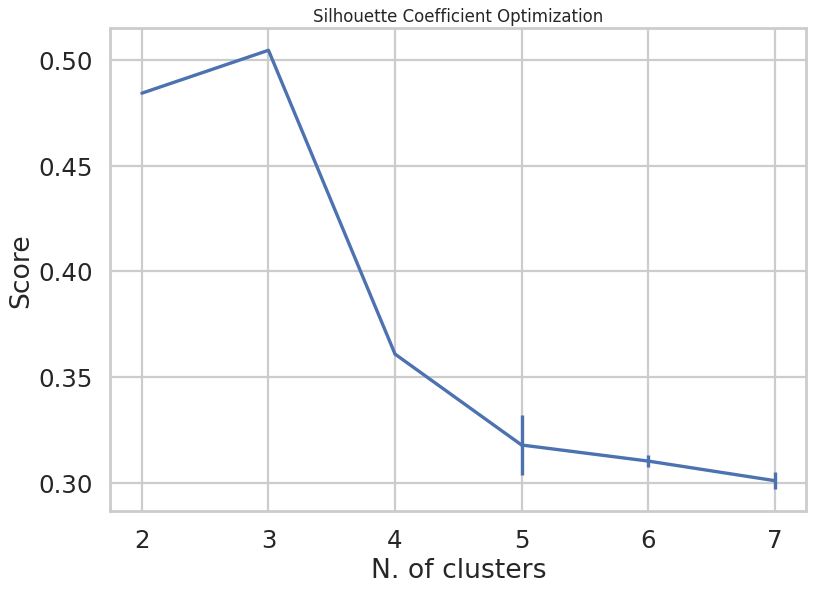

In [70]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 8)
sils=[]
sils_err=[]
v_scores = []
v_scores_temp=[]
v_scores1=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        kmeans = KMeans(n_clusters=n,n_init=2)
        kmeans.fit(X)
        labels = kmeans.labels_
        sil=silhouette_score(X, labels, metric='euclidean')
        tmp_sil.append(sil)
        labels2 = kmeans.predict(X)   
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    #v_scores_temp=np.mean(SelBest(np.array(v_scores), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)
    v_scores.append(v_measure_score(X[:,0], labels2)) 
    #v_scores1.append(v_scores_tem)

plt.figure(figsize=(10, 8), dpi=80)
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Coefficient Optimization", fontsize=15)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

**Elbow Method**

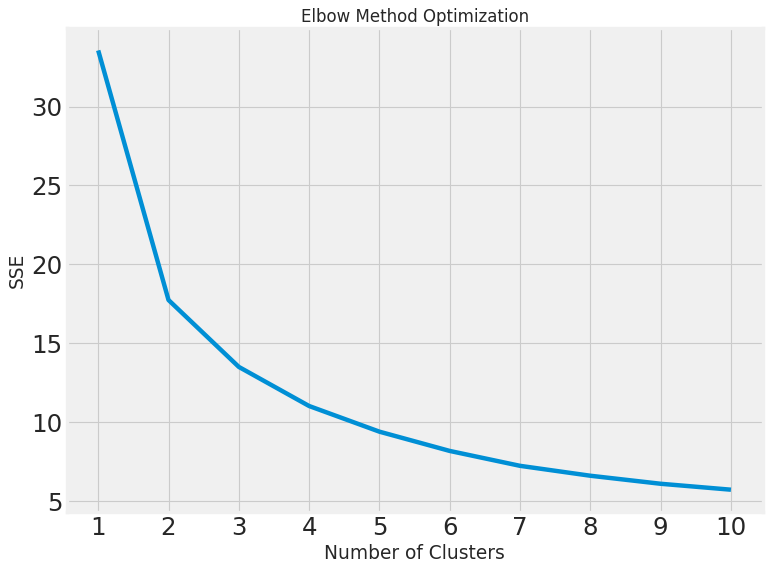

In [71]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
   # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
     kmeans.fit(X)
     sse.append(kmeans.inertia_)
     
plt.figure(figsize=(10, 8), dpi=80)
plt.style.use("fivethirtyeight")
plt.title("Elbow Method Optimization", fontsize=15)
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Gaussian Mixture Model with TF-IDF

In [72]:
np.random.seed(42)
gmm = GaussianMixture(n_components = 4) 
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(text.todense())
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

,P1,P2
0,-0.079594,-0.029543
1,-0.057216,-0.023737


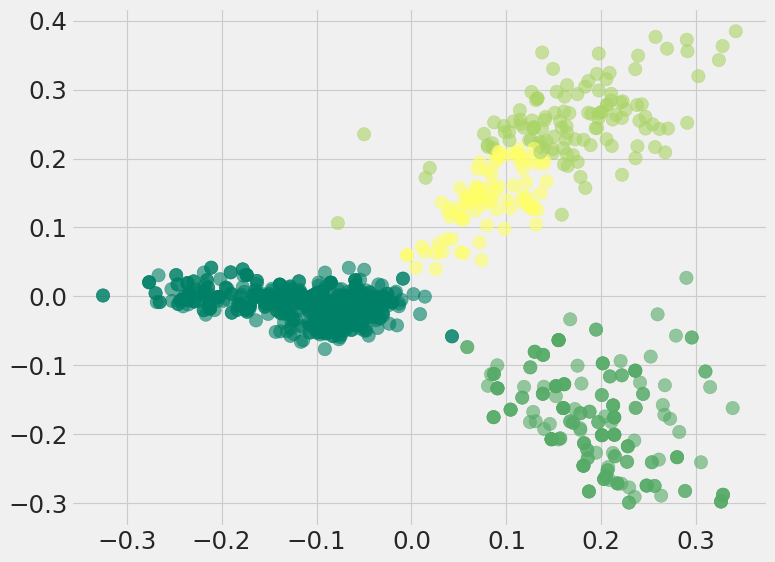

In [73]:
gmm = GaussianMixture(n_components = 4) 
gmm.fit(X_principal)

# Visualizing the clustering
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = GaussianMixture(n_components = 4).fit_predict(X_principal), cmap =plt.cm.summer, alpha = 0.6) 
plt.show() 

**Silhouette Score**

Text(0, 0.5, 'Score')

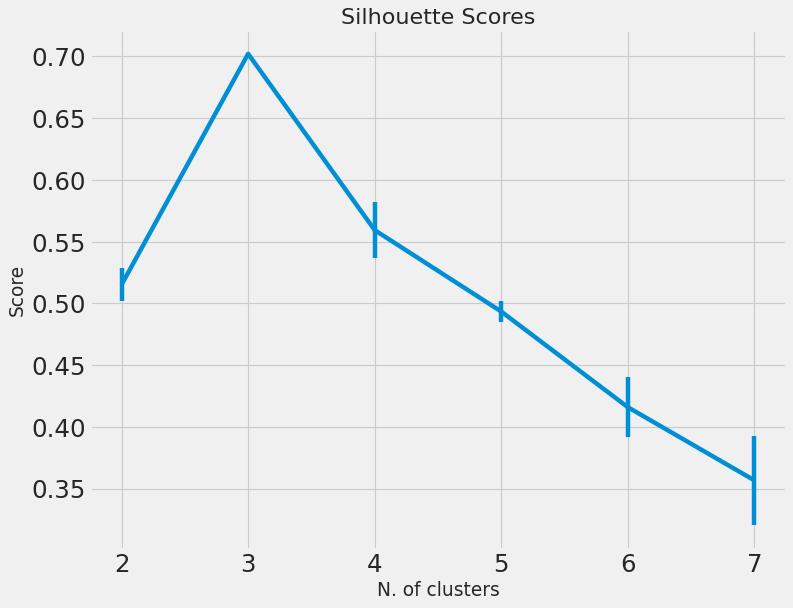

In [74]:
n_clusters=np.arange(2, 8)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_principal) 
        labels=gmm.predict(X_principal)
        sil=silhouette_score(X_principal, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

plt.figure(figsize=(10, 8), dpi=80)
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

**Distance between GMMs**

Here we form two datasets, each with an half randomly choose amount of data. We will then check how much the GMMs trained on the two sets are similar, for each configuration.

Since we are talking about distributions, the concept of similarity is embedded in the Jensen-Shannon (JS) metric. The lesser is the JS-distance between the two GMMs, the more the GMMs agree on how to fit the data.

The lower the distance, the better the cluster.

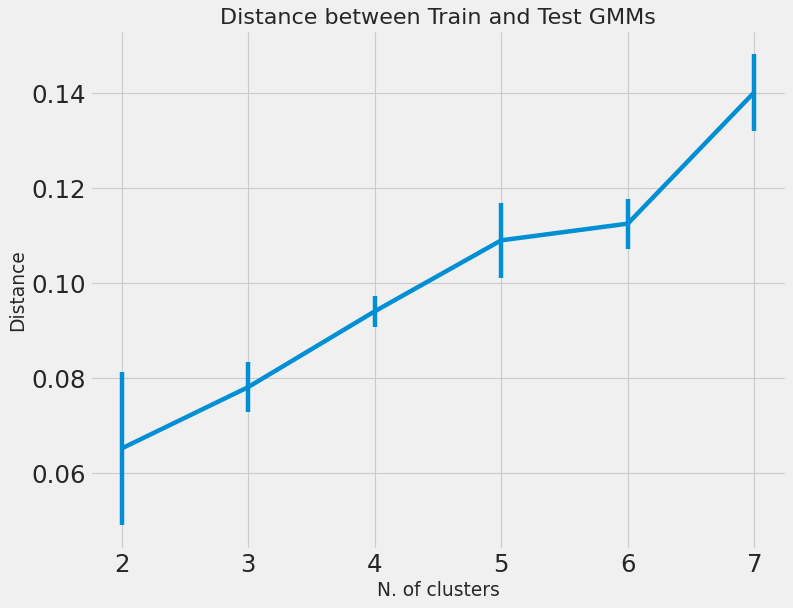

In [75]:
#Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)
    
n_clusters=np.arange(2, 8)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(X_principal, test_size=0.5)
        
        gmm_train=GaussianMixture(n, n_init=2).fit(train) 
        gmm_test=GaussianMixture(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

plt.figure(figsize=(10, 8), dpi=80)
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

**Bayesian Information Criterion (BIC)**

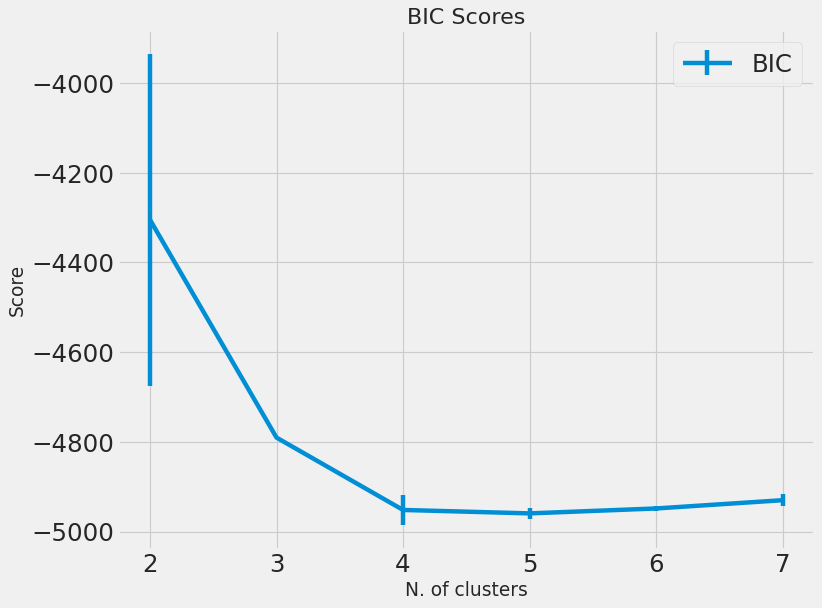

In [76]:
n_clusters=np.arange(2, 8)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_principal) 
        
        tmp_bic.append(gmm.bic(X_principal))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

plt.figure(figsize=(10, 8), dpi=80)
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

<Figure size 800x640 with 0 Axes>

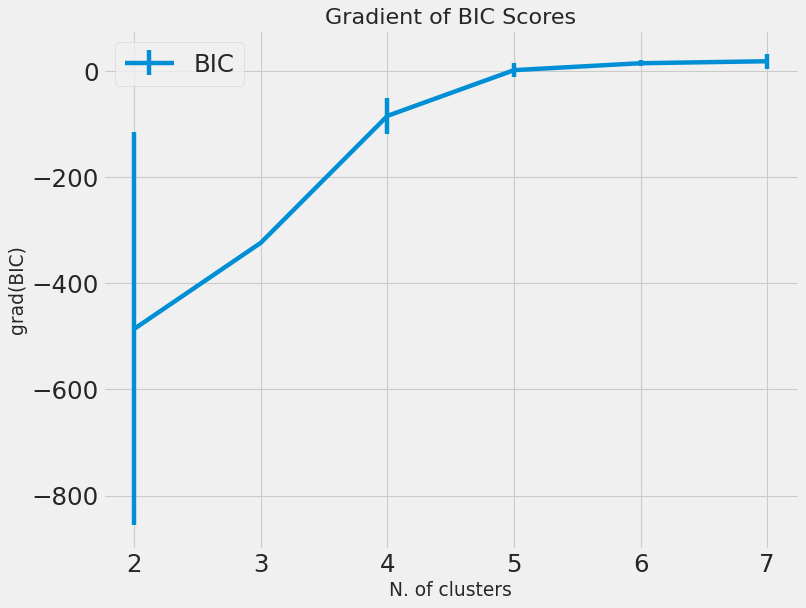

In [77]:
plt.figure(figsize=(10, 8), dpi=80)
plt.figure(figsize=(10, 8), dpi=80)
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

### Hierarchical Clustering

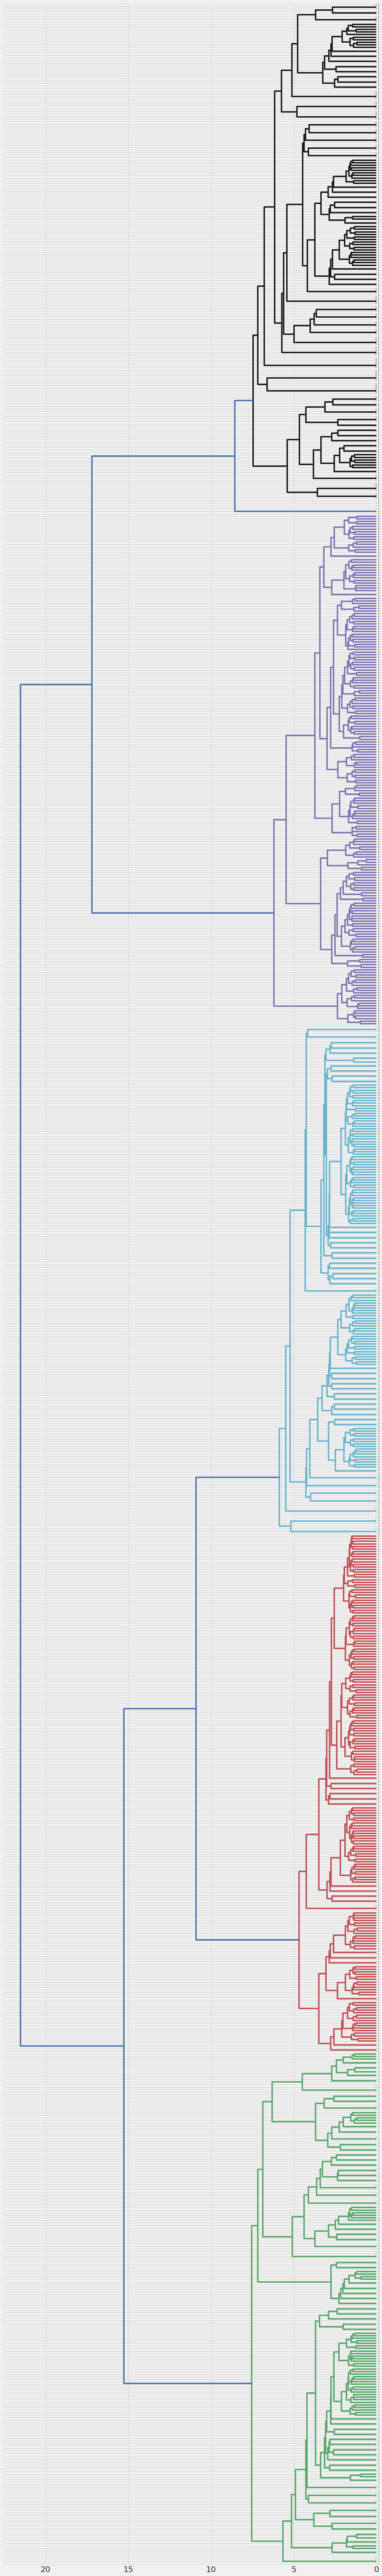

In [78]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df['Data'])

dist = 1 - cosine_similarity(X)
linkage_matrix = ward(dist)
color = max(linkage_matrix[:,2]) * 0.39
fig, ax = plt.subplots(figsize=(15, 100)) # set size
ax = dendrogram(linkage_matrix, orientation="left", leaf_font_size=6, labels=df['Target'].tolist(), color_threshold=color)
plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')
plt.tight_layout()